In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os
from PIL import Image
import random
import warnings
warnings.filterwarnings('ignore')


2025-09-26 10:56:24.875626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758884185.084923      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758884185.144241      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1) # Veri Setinin Yüklenmesi ve İncelenmesi
Veri dizin yapısını kontrol etme:

Grafik ayarları

In [2]:
plt.style.use('ggplot')
sns.set_palette("husl")

Veri dizin yapısını kontrol etme:

In [3]:
data_dir = '/kaggle/input/brain-tumor-mri-dataset'
training_dir = os.path.join(data_dir, 'Training')
testing_dir = os.path.join(data_dir, 'Testing')

In [4]:
class_names = os.listdir(training_dir)
print("Sınıflar:", class_names)


Sınıflar: ['pituitary', 'notumor', 'meningioma', 'glioma']


Veri kümesinde yer alan sınıflar;

pituitary :Hipofiz bezi tümörleri

glioma :Glial hücrelerden kaynaklanan tümörler

meningioma :Beyin zarı tümörleri

no_tumor :Tümör içermeyen MRI görüntüleri

Her sınıftaki görüntü sayısını sayalım

In [5]:
train_counts = {}
test_counts = {}

for class_name in class_names:
    train_path = os.path.join(training_dir, class_name)
    test_path = os.path.join(testing_dir, class_name)
    
    train_counts[class_name] = len(os.listdir(train_path))
    test_counts[class_name] = len(os.listdir(test_path))

print("\nEğitim seti dağılımı:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} görüntü")

print("\nTest seti dağılımı:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count} görüntü")


Eğitim seti dağılımı:
pituitary: 1457 görüntü
notumor: 1595 görüntü
meningioma: 1339 görüntü
glioma: 1321 görüntü

Test seti dağılımı:
pituitary: 300 görüntü
notumor: 405 görüntü
meningioma: 306 görüntü
glioma: 300 görüntü


Her sınıftan örnek görüntüleri gösterme

Resim dosyası yapısını kontrol edelim

In [6]:

for class_name in class_names:
    class_path = os.path.join(training_dir, class_name)
    if os.path.exists(class_path):
        files = os.listdir(class_path)
        img_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'))]
        print(f" {class_name}: {len(img_files)} resim dosyası")
    else:
        print(f" {class_name} klasörü bulunamadı: {class_path}")

 pituitary: 1457 resim dosyası
 notumor: 1595 resim dosyası
 meningioma: 1339 resim dosyası
 glioma: 1321 resim dosyası


Her Sınıftan Bir Örnek Görüntü Gösterimi

 pituitary: Tr-pi_0532.jpg başarıyla yüklendi
 notumor: Tr-no_0482.jpg başarıyla yüklendi
 meningioma: Tr-me_0529.jpg başarıyla yüklendi
 glioma: Tr-gl_0954.jpg başarıyla yüklendi


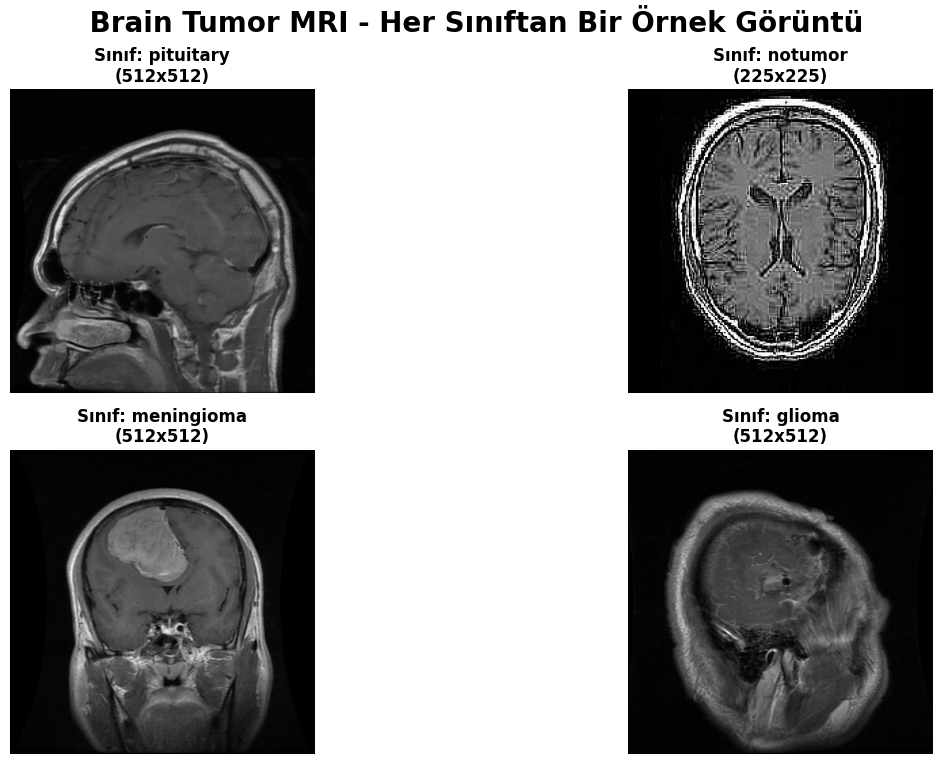

In [7]:

plt.figure(figsize=(15, 8))

for i, class_name in enumerate(class_names):
    try:
        # Sınıf yolunu oluştur
        class_path = os.path.join(training_dir, class_name)
        
        # Klasörün var olduğundan emin ol
        if not os.path.exists(class_path):
            print(f" Klasör bulunamadı: {class_path}")
            continue
            
        # Klasördeki resim dosyalarını al
        img_files = [f for f in os.listdir(class_path) 
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
        
        if not img_files:
            print(f"{class_name} klasöründe resim dosyası bulunamadı")
            # Boş subplot göster
            plt.subplot(2, 2, i+1)
            plt.text(0.5, 0.5, 'Resim\nBulunamadı', 
                    ha='center', va='center', fontsize=12, transform=plt.gca().transAxes)
            plt.title(f'Sınıf: {class_name}', fontweight='bold')
            plt.axis('off')
            continue
        
        # İlk resmi seç (veya rastgele bir resim seçmek için: random.choice(img_files))
        sample_file = img_files[0]
        sample_path = os.path.join(class_path, sample_file)
        
        # Görüntüyü yükle
        img = Image.open(sample_path)
        
        # Subplot oluştur
        plt.subplot(2, 2, i+1)  # 2x2 grid, 4 sınıf için ideal
        
        # Görüntüyü göster (MRI görüntüleri için gri tonlamalı)
        if img.mode == 'L':  # Gri tonlamalı
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
            
        plt.title(f'Sınıf: {class_name}\n({img.size[0]}x{img.size[1]})', 
                 fontweight='bold', fontsize=12)
        plt.axis('off')
        
        print(f" {class_name}: {sample_file} başarıyla yüklendi")
        
    except Exception as e:
        print(f"{class_name} yüklenirken hata: {str(e)}")
        # Hata durumunda boş subplot
        plt.subplot(2, 2, i+1)
        plt.text(0.5, 0.5, 'Yükleme\nHatasi', 
                ha='center', va='center', fontsize=12, color='red', 
                transform=plt.gca().transAxes)
        plt.title(f'Sınıf: {class_name}', fontweight='bold')
        plt.axis('off')

plt.suptitle(' Brain Tumor MRI - Her Sınıftan Bir Örnek Görüntü', 
             fontsize=20, fontweight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()



her sınıftan iki örnek görüntü

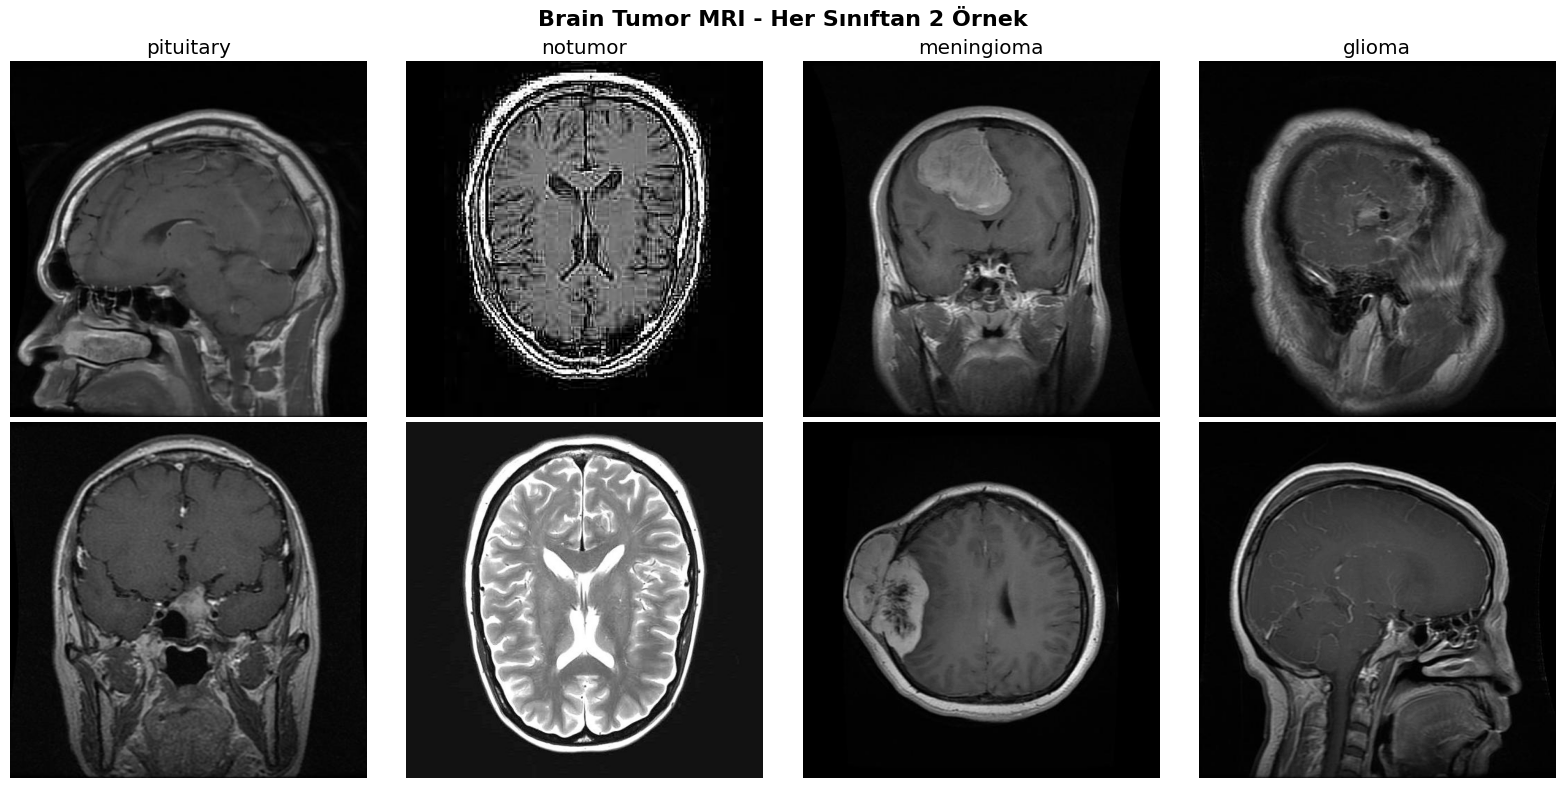

Hiperparametre optimizasyonu hazır


In [8]:
# 

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(training_dir, class_name)
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:2]
    
    for j, img_file in enumerate(img_files):
        img_path = os.path.join(class_path, img_file)
        img = plt.imread(img_path)
        
        axes[j, i].imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        axes[j, i].set_title(f'{class_name}' if j == 0 else '')
        axes[j, i].axis('off')

plt.suptitle('Brain Tumor MRI - Her Sınıftan 2 Örnek', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ## 10. ⚙️ Hiperparametre Optimizasyonu

import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    
    for i in range(hp.Int('conv_layers', 2, 4)):
        model.add(Conv2D(hp.Int(f'filters_{i}', 32, 128, step=32), (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5)))
    
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', 128, 512, step=128), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))
    
    model.compile(
        optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Hiperparametre optimizasyonu hazır")

Bir sınıfta kaç adet görüntü olduğunu görelim:

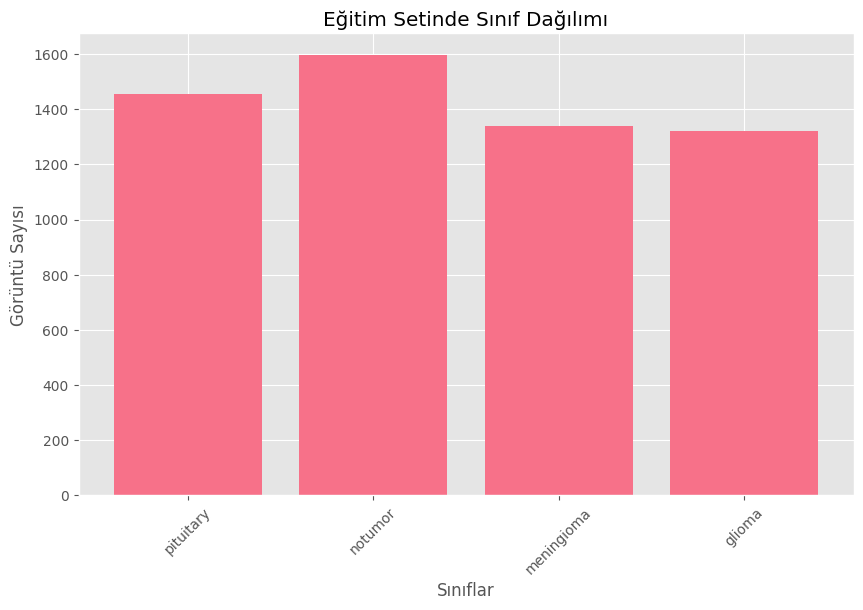

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(train_counts.keys(), train_counts.values())
plt.title('Eğitim Setinde Sınıf Dağılımı')
plt.xlabel('Sınıflar')
plt.ylabel('Görüntü Sayısı')
plt.xticks(rotation=45)
plt.show()


Görüntü boyutlarını belirliyoruz (VGG16 için 224x224 alıyoruz)

In [10]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

Eğitim verisi için augmentation uyguluyoruz

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # Validation için %20 ayır
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


Eğitim verisi için augmentation uyguluyoruz

Eğitim verisi generator'ı

In [13]:
test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Eğitim örnekleri: {train_generator.samples}")
print(f"Validation örnekleri: {validation_generator.samples}")
print(f"Test örnekleri: {test_generator.samples}")

Found 1311 images belonging to 4 classes.
Eğitim örnekleri: 4571
Validation örnekleri: 1141
Test örnekleri: 1311


Validation verisi generator'ı

In [14]:
validation_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',                   # Validation için olan kısmı al
    shuffle=True,
    seed=42
)

Found 1141 images belonging to 4 classes.


# CNN MODELİ OLUŞTURMA

In [15]:
def create_cnn_model():
    model = Sequential([
        # İlk Conv Block
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # İkinci Conv Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
       
        # Üçüncü Conv Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Dördüncü Conv Block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

         # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')  # 4 sınıf
    ])
    
    return model



Modeli oluşturma ve özetini gösterme

In [16]:
cnn_model = create_cnn_model()
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("CNN Model Özeti:")
cnn_model.summary()


I0000 00:00:1758884207.788271      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758884207.789001      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


CNN Model Özeti:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 19,399,620 (74.00 MB)

 Trainable params: 19,397,636 (74.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

# Model Eğitimi

In [17]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


Model Eğitimi

In [18]:
history = cnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50


I0000 00:00:1758884217.877908      94 service.cc:148] XLA service 0x7a330801a490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758884217.878914      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758884217.878939      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758884218.691907      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/143 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.2500 - loss: 2.7903 

I0000 00:00:1758884229.049380      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 124s 744ms/step - accuracy: 0.5499 - loss: 1.2633 - val_accuracy: 0.2550 - val_loss: 9.5442 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 527ms/step - accuracy: 0.6397 - loss: 0.9228 - val_accuracy: 0.2603 - val_loss: 3.5375 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 537ms/step - accuracy: 0.6761 - loss: 0.8215 - val_accuracy: 0.3786 - val_loss: 2.9801 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 530ms/step - accuracy: 0.7349 - loss: 0.7062 - val_accuracy: 0.2883 - val_loss: 5.7340 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 519ms/step - accuracy: 0.7497 - loss: 0.6275 - val_accuracy: 0.2901 - val_loss: 10.6372 - learning_rate: 0.0010
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 75s 525ms/step - accuracy: 0.7708 - loss: 0.6040 - val_accuracy: 0.3506 - val_loss: 3.5126 - learning_rate: 0.0010
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 520ms/step - accuracy: 0.7758 - los

# Model Değerlendirme

Loss ve Accuracy grafikleri

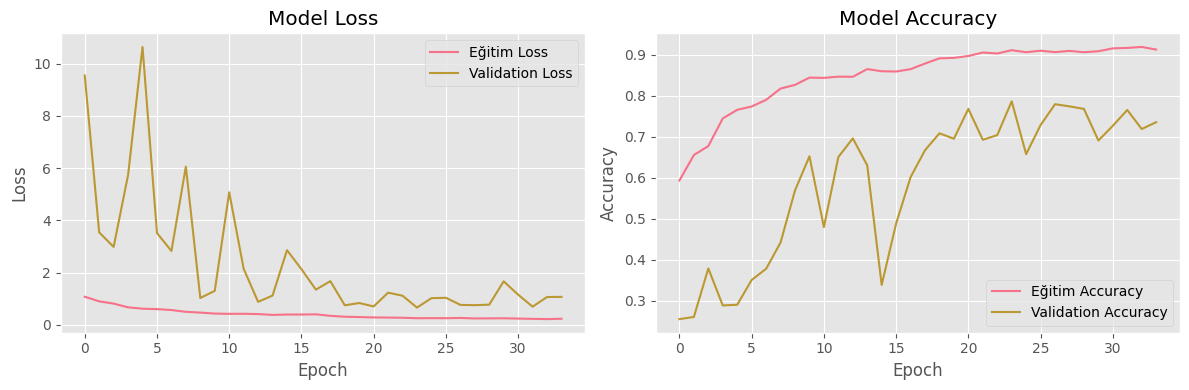

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Test seti üzerinde değerlendirme

In [20]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.6494 - loss: 0.9953

Test Accuracy: 0.7674
Test Loss: 0.6681


Tahminler

In [21]:
y_pred = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step


Confusion Matrix

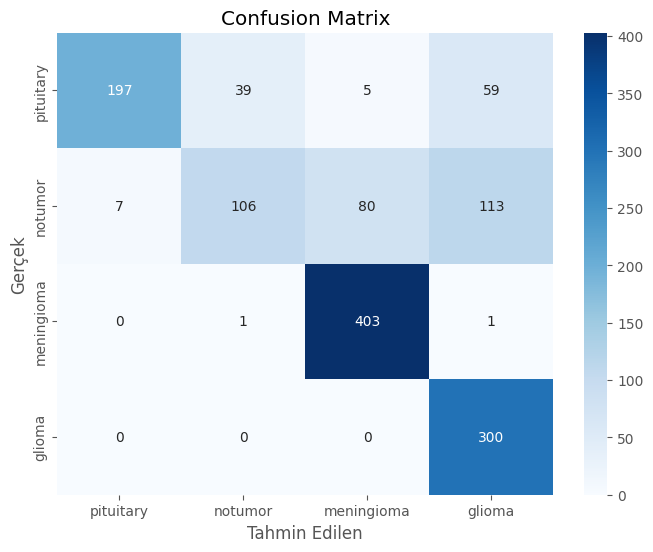

In [22]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.show()

Classification Report

In [23]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

   pituitary       0.97      0.66      0.78       300
     notumor       0.73      0.35      0.47       306
  meningioma       0.83      1.00      0.90       405
      glioma       0.63      1.00      0.78       300

    accuracy                           0.77      1311
   macro avg       0.79      0.75      0.73      1311
weighted avg       0.79      0.77      0.74      1311



Transfer Learning (VGG16)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 Model Özeti:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,068 (56.64 MB)

 Trainable params: 132,868 (519.02 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

 VGG16 modeli eğitiliyor (Bonus bölüm)...
Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 123s 729ms/step - accuracy: 0.4495 - loss: 1.3569 - val_accuracy: 0.6004 - val_loss: 1.1728 - learning_rate: 1.0000e-04
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 563ms/step - accuracy: 0.6975 - loss: 0.7701 - val_accuracy: 0.6380 - val_loss: 0.9664 - learning_rate: 1.0000e-04
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 555ms/step - accuracy: 0.7703 - loss: 0.6085 - val_accuracy: 0.7046 - val_loss: 0.7978 - learning_rate: 1.0000e-04
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 553ms/step - accuracy: 0.7860 - loss: 0.5734 - val_accuracy: 0.6573 - val_loss: 0.9115 - learning_rate: 1.0000e-04
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 556ms/step - accuracy: 0.7946 - loss: 0.5409 - val_accuracy: 0.7143 - val_loss: 0.7479 - learning_rate: 1.0000e-04
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 80s 560ms/step - accuracy: 0.8240 - loss: 0.4886 - val_accuracy: 0.7046 - val_loss: 0.7843 - learning_rate: 1.0000e-04
Epo

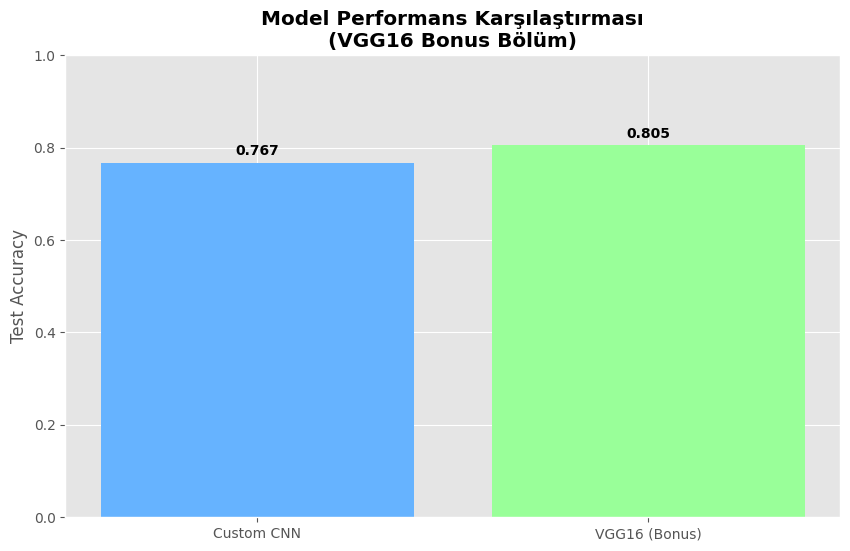

In [24]:
# Transfer Learning (VGG16)

def create_vgg16_model():
    
    
    # ImageNet'te önceden eğitilmiş VGG16 modelini yükle
    base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    # Önceden eğitilmiş katmanları dondur
    base_model.trainable = False
    
    # Yeni modeli oluştur - DÜZGÜN GİRENTİ İLE
    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    
    return model

# VGG16 modelini oluştur
vgg_model = create_vgg16_model()
vgg_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("VGG16 Model Özeti:")
vgg_model.summary()

# VGG16 modelini eğit
print(" VGG16 modeli eğitiliyor (Bonus bölüm)...")
vgg_history = vgg_model.fit(
    train_generator,
    epochs=15,  # Daha az epoch yeterli
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# VGG16 değerlendirme
vgg_test_loss, vgg_test_accuracy = vgg_model.evaluate(test_generator)
print(f"\n VGG16 Test Accuracy: {vgg_test_accuracy:.4f}")
print(f" VGG16 Test Loss: {vgg_test_loss:.4f}")

# Model karşılaştırması
models_comparison = {
    'Custom CNN': test_accuracy,
    'VGG16 (Bonus)': vgg_test_accuracy
}

plt.figure(figsize=(10, 6))
bars = plt.bar(models_comparison.keys(), models_comparison.values(), 
               color=['#66b3ff', '#99ff99'])
plt.title('Model Performans Karşılaştırması\n(VGG16 Bonus Bölüm)', fontweight='bold')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)

# Çubukların üzerine değerleri yaz
for bar, accuracy in zip(bars, models_comparison.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{accuracy:.3f}', ha='center', va='bottom', fontweight='bold')

plt.show()

In [25]:
def grad_cam(model, img_array, layer_name):
    # Grad-CAM implementasyonu buraya eklenecek
    pass


HİPERPARAMETRE OPTİMİZASYONU

In [26]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(), MaxPooling2D(2,2), Dropout(0.25),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(), MaxPooling2D(2,2), Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'), Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
history = model.fit(
    train_generator,
    epochs=2,  # Hızlı test
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/2
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 551ms/step - accuracy: 0.3807 - loss: 23.8839 - val_accuracy: 0.2314 - val_loss: 119.1591
Epoch 2/2
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 521ms/step - accuracy: 0.3627 - loss: 1.3013 - val_accuracy: 0.2358 - val_loss: 139.6632


In [28]:
model.save('brain_tumor_cnn.h5')

vgg_model.save('brain_tumor_vgg.h5')
print("Model kaydedildi!")

Model kaydedildi!


Sonuç karşılaştırma

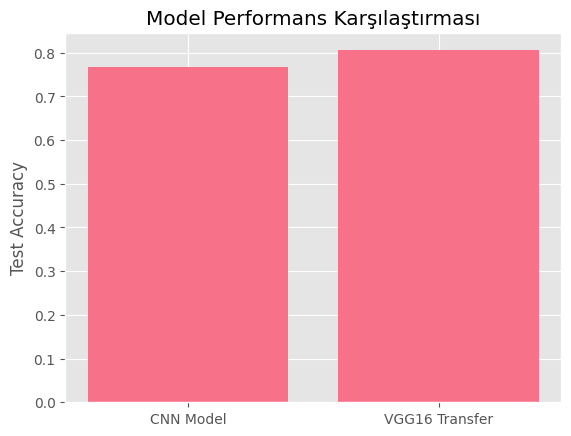

🎉 PROJE TAMAMLANDI!
📊 Sonuçlar:
   - CNN Model Test Accuracy: 0.7674
   - VGG16 Transfer Learning: 0.8055


In [29]:
models_comparison = {'CNN Model': test_accuracy, 'VGG16 Transfer': vgg_test_accuracy}
plt.bar(models_comparison.keys(), models_comparison.values())
plt.title('Model Performans Karşılaştırması')
plt.ylabel('Test Accuracy')
plt.show()

print("🎉 PROJE TAMAMLANDI!")
print("📊 Sonuçlar:")
print(f"   - CNN Model Test Accuracy: {test_accuracy:.4f}")
print(f"   - VGG16 Transfer Learning: {vgg_test_accuracy:.4f}")